In [ ]:
# import libraries
from torch import nn as nn
import torch
import torch.autograd
import numpy as np
import matplotlib.pyplot as plt

#Solving System of ODEs

use neural net to estimate parameters $\lambda_{1}$ and $\lambda_{2}$

$x_{1}' = \lambda_{1}x_{2} - x_{1}, \lambda_{1} = 2$






$x_1(0) = 1$

$x_{2}' = \lambda_{2}x_{1}, \lambda_{2} = 1$

$x_{2}(0) = 0$

#Analytical Solution

$x_{1}(t) = \frac{2}{3}(2e^{-2t}+e^{t}) $

$x_{2}(t) = -\frac{1}{3}(-e^{-2t}+e^{t}) $

# Setup NN to estimate value of dependent variable

In [ ]:
# Establish Neural network class for outlining the architecure employed, used as constructor for neural network object:
# input size = 1: input is select collocation points of time data
# hidden layers = 5, hidden nodes = 10: Arbitrarily decided, hyperparameters needs to be checked via validation (grid search etc)
# output layer size = 2: estimation of dependent variables x1 and x2
class UNN(nn.Module):
    def __init__(self, input_size = 1, output_size = 2, hidden_layers = 5, hidden_nodes = 10):
        super().__init__()
        self.input_layer  = nn.Linear(input_size, hidden_nodes) # first layer: input to hidden size: ie 1 to 10
        self.hidden_layers_list = nn.ModuleList([nn.Linear(hidden_nodes, hidden_nodes)] * hidden_layers) # hidden layers, hidden to hidden layer: ie 10 to 10
        self.output_layer = nn.Linear(hidden_nodes, output_size) # hidden to output layer: 10 to 2 (prediction)
        self.activation_function = nn.Tanh() # Construct activation fxn

    def forward(self, t):
        t = self.activation_function(self.input_layer(t)) #Input to first hidden layer
        for hidden_layer in self.hidden_layers_list:  #Passes the previous layer input through a hidden layer, followed by an activation, repeating for all hidden layers
            t = self.activation_function(hidden_layer(t))
        t = self.output_layer(t) # last hidden layer to output, no activations applied as this is the prediction
        return t

# Data and pre-processing

In [ ]:
# Solution of the above differential equation on time domain of 0 to 2 seconds
t = np.linspace(0,2,1000) # domain of 0 to 2 s, take 1000 collocation points evenly
x_1 = (2*np.exp(-2*t)+np.exp(t))/3 # True x_1 solution
x_2 = (-np.exp(-2*t)+np.exp(t))/3 # True x_2 solution
lambda1_actual = 2
lambda2_actual = 1

In [ ]:
# Dataset illustrated
import pandas as pd
data = {'t': np.ravel(t), 'x_1': np.ravel(x_1), 'x_2': np.ravel(x_2)}
df = pd.DataFrame(data)
df.head(10)

,t,x_1,x_2
0,0.000000,1.000000,0.000000
1,0.002002,0.998004,0.002000
2,0.004004,0.996020,0.003996
3,0.006006,0.994048,0.005988
4,0.008008,0.992088,0.007976
5,0.010010,0.990139,0.009960
6,0.012012,0.988203,0.011941
7,0.014014,0.986278,0.013917
8,0.016016,0.984365,0.015890
9,0.018018,0.982464,0.017859


In [ ]:
# Data Loss evaluation with respect to datapoints available:
# prepare data as tensor for processing with neural network
t = t.reshape(-1,1)
t_data = t[0:400:40] # use 40% of total range as training data, take 10 points evenly from range
t_train = torch.tensor(t_data, dtype=torch.float32, device="cpu") #convert to torch tensor
x_1 = x_1.reshape(-1,1)
x_1_data = x_1[0:400:40] # use 40% of total range as training data
x_1_train = torch.tensor(x_1_data, dtype=torch.float32, device="cpu") #convert to torch tensor
t = t.reshape(-1,1)
t_data = t[0:400:40] # use 40% of total range as training data, take 10 points evenly from range
t_train = torch.tensor(t_data, dtype=torch.float32, device="cpu") #convert to torch tensor
x_2 = x_2.reshape(-1,1)
x_2_data = x_2[0:400:40] # use 40% of total range as training data
x_2_train = torch.tensor(x_2_data, dtype=torch.float32, device="cpu") #convert to torch tensor
x_train = torch.cat((x_1_train,x_2_train), 1) # concatentate data into tensor with two columns, for matching dimensionality of neural network output
# NN output size = 2 (from above), ie tensor 2 columns, need to match to perform evaluation

Text(0, 0.5, 'Dependent Variables Value')

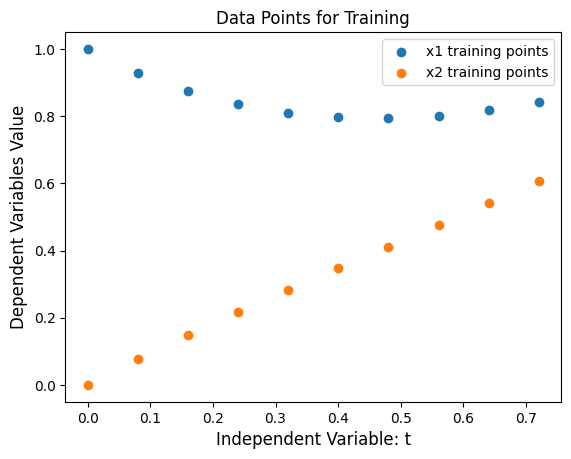

In [ ]:
plt.title("Data Points for Training")
plt.scatter(t_train, x_1_train)
plt.scatter(t_train, x_2_train)
plt.legend(["x1 training points", "x2 training points"])
plt.xlabel("Independent Variable: t", fontsize=12)
plt.ylabel("Dependent Variables Value", fontsize=12)


# Initialize and Optimize PINN

In [ ]:
# inital guesses for parameters
lambda1 = nn.Parameter(torch.tensor([1.7], requires_grad=True).float())
lambda2 = nn.Parameter(torch.tensor([1.3], requires_grad=True).float())

In [ ]:
pinn = UNN() # using the constructor, construct neural network object
pinn.register_parameter('lambda1', lambda1) #register parameter to be optimized in the neural network
pinn.register_parameter('lambda2', lambda2) #register parameter to be optimized in the neural network
optim = torch.optim.Adam(pinn.parameters(), lr=0.0001) # using the Adam algorithm, for first-order gradient-based optimization of stochastic objective functions
mse_loss = nn.MSELoss() # mean squared error object construction
t_physics = torch.linspace(0, 2, 20, requires_grad=True, device="cpu", dtype=torch.float32).reshape(-1,1) # range for prediction for ODE loss eval

In [ ]:
epochs = 50000 # train 50000 iterations
loss_over_training = []
for epoch in range(epochs):
    optim.zero_grad() #zeros out all the gradients (by default torch accumulates gradients)

    # use NN to predict output purely from data, (limited range of training data above):
    x_nn = pinn(t_train) # prediction of x1 and x2 (from time data of 40% of total range, total 10 points)
    data_loss = mse_loss(x_nn, x_train) # eval mean squared error, deviation of prediction from true data for those 10 points

    # use NN to predict output over entire domain of interest, based on reconstructing ODE
    x_ode = pinn(t_physics) # preduction over entire range, using time data collocation points
    x_1_nn, x_2_nn = torch.split(x_ode.t(),1) # predicition is tensor, 2 columns, split into prediction of x_1 and x_2
    x_1_nn = x_1_nn.t() #predicition of x_1 over entire range
    x_2_nn = x_2_nn.t() #predicition of x_2 over entire range
    dx_1 = torch.autograd.grad(x_1_nn, t_physics, torch.ones_like(x_1_nn), create_graph=True)[0] #automatic differentiation of predicted x1,  wrt entire time domain
    dx_2 = torch.autograd.grad(x_2_nn, t_physics, torch.ones_like(x_2_nn), create_graph=True)[0] #automatic differentiation of predicted x2,  wrt entire time domain

    # SEE ORIGINAL ODES, loss calcuated by moving leftside to right side
    # optimisation seeks to minimize loss (ie loss to 0), by re-arranging original ODES, match the equation to the loss
    # In addition to reconstructing the ode, network seeks optimal values for parameters lambda1 and lambda2
    ode_loss_1 = dx_1 - lambda1*x_2_nn + x_1_nn # loss with respect to diffential equation: x1'- 2*x2 + x1 = 0
    ode_loss_2 = dx_2 - lambda2*x_1_nn  # loss with respect to diffential equation: x2'- x1 = 0

    # Mean squared error (essentially, the evaluated re-arranged ODE (loss) deivation wrt 0)
    physics_loss_1 = torch.mean(ode_loss_1**2)
    physics_loss_2 = torch.mean(ode_loss_2**2)

    # NOTE:
    # In this case, real data is known, bypassing the need for a boundary condition loss
    # real data determines the exact solution ODE in conjunction with regularization term "physics_loss"
    # In the case where ground-truth data (training data) is not aviailable, able to determine exact solution with ODE loss and BC/IC loss

    loss = data_loss + physics_loss_1 + physics_loss_2  # hybrid physics informed and data driven loss
    loss.backward() # gradient descent
    optim.step() # optimize using the specified algorithm and learning rate
    if epoch % 1000 == 0: # Print out the error(loss) and estimated parameters every 1000 optimization cycles
        print(f"Epochs = {epoch} of {epochs}, Loss = {float(loss):.7f}, params = {lambda1.item(), lambda2.item()}")
        loss_over_training.append(loss)

Epochs = 0 of 50000, Loss = 0.6176122, params = (1.6999000310897827, 1.299899935722351)
Epochs = 1000 of 50000, Loss = 0.2590616, params = (1.6486926078796387, 1.2028743028640747)
Epochs = 2000 of 50000, Loss = 0.1730241, params = (1.5047693252563477, 1.089803695678711)
Epochs = 3000 of 50000, Loss = 0.1308792, params = (1.4012846946716309, 0.9851481914520264)
Epochs = 4000 of 50000, Loss = 0.1014145, params = (1.292370080947876, 0.8829530477523804)
Epochs = 5000 of 50000, Loss = 0.0376606, params = (1.1724629402160645, 0.7858347296714783)
Epochs = 6000 of 50000, Loss = 0.0041068, params = (1.1334561109542847, 0.7557746171951294)
Epochs = 7000 of 50000, Loss = 0.0031485, params = (1.1337342262268066, 0.7573158144950867)
Epochs = 8000 of 50000, Loss = 0.0028288, params = (1.1467326879501343, 0.7700194120407104)
Epochs = 9000 of 50000, Loss = 0.0025113, params = (1.1699278354644775, 0.7916861176490784)
Epochs = 10000 of 50000, Loss = 0.0021165, params = (1.2060949802398682, 0.82285511493

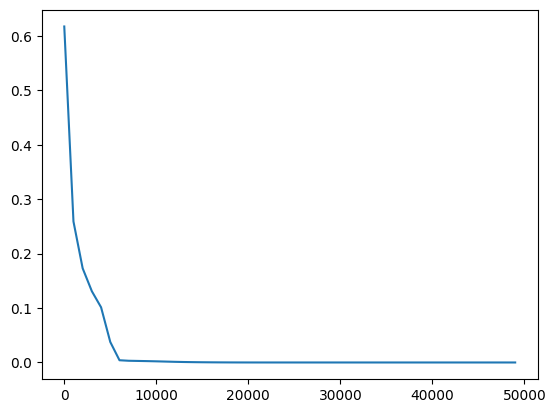

In [ ]:
loss_over_training = [x.detach().numpy() for x in loss_over_training]
plt.plot(np.arange(0,epochs,1000), loss_over_training)

In [ ]:
print(f"The values of the parameters predicted by the PINN are: λ1 = {lambda1.item()}, and λ2 = {lambda2.item()}")
print(f"The real values of the parameters are: λ1 = {lambda1_actual}, and λ2 = {lambda2_actual}")

The values of the parameters predicted by the PINN are: λ1 = 1.9993023872375488, and λ2 = 0.9997345805168152
The real values of the parameters are: λ1 = 2, and λ2 = 1


# Evaluation of PINN on entire range

In [ ]:
pinn.eval() # sets the neural network to evaluation mode, ie no longer training parameters (self.training = False).
u_nn = pinn(torch.tensor(t, dtype = torch.float32, device="cpu").reshape(-1,1)) # try to solve for variables over entire range
x_1_out, x_2_out = torch.split(u_nn.t(),1) # split output into x_1 and x_2
x_1_out = x_1_out.t().detach().cpu().numpy()
x_2_out = x_2_out.t().detach().cpu().numpy()

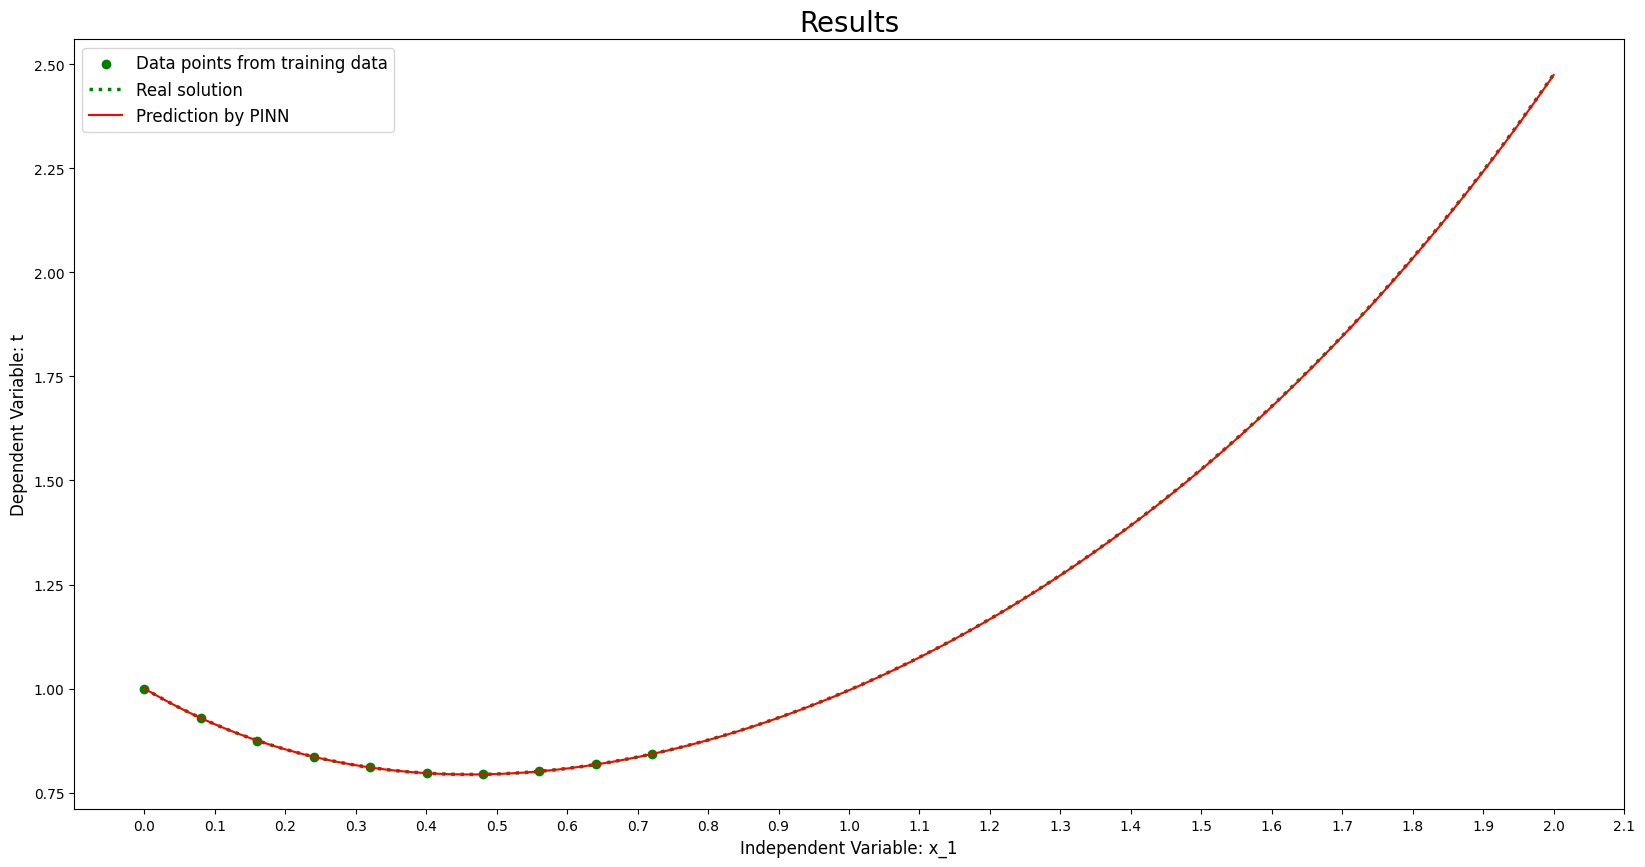

In [ ]:
# plot of x1 wrt time
plt.figure(figsize=(20, 10))
plt.xticks(np.arange(0, 2.5, step=0.1))
plt.title("Results", fontsize=20)
plt.xlabel("Independent Variable: x_1", fontsize=12)
plt.ylabel("Dependent Variable: t", fontsize=12)

plt.scatter(t_data.reshape(-1,), x_1_data.reshape(-1,), c="g", label="Data points from training data")
plt.plot(t, x_1, label="Real solution", linewidth=2.5, linestyle='dotted', c='g')
plt.plot(t, x_1_out, label="Prediction by PINN", c="r")


plt.legend(fontsize="large")
plt.show()

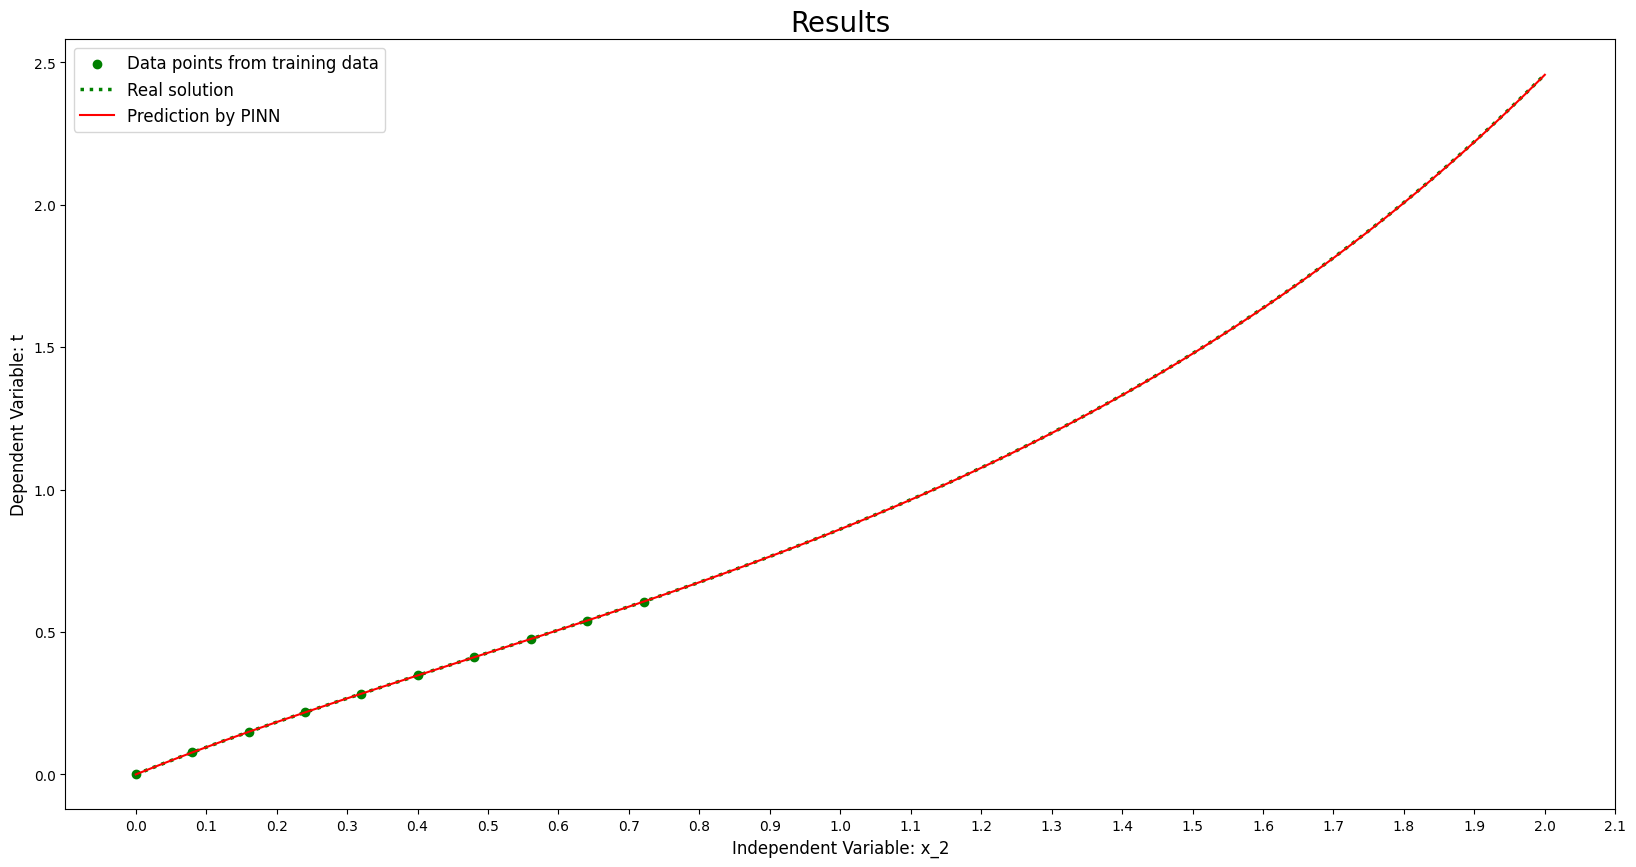

In [ ]:
# plot of x2 wrt time
plt.figure(figsize=(20, 10))
plt.xticks(np.arange(0, 2.5, step=0.1))
plt.title("Results", fontsize=20)
plt.xlabel("Independent Variable: x_2", fontsize=12)
plt.ylabel("Dependent Variable: t", fontsize=12)

plt.scatter(t_data.reshape(-1,), x_2_data.reshape(-1,), c="g", label="Data points from training data")
plt.plot(t, x_2, label="Real solution", linewidth=2.5, linestyle='dotted', c='g')
plt.plot(t, x_2_out, label="Prediction by PINN", c="r")


plt.legend(fontsize="large")
plt.show()

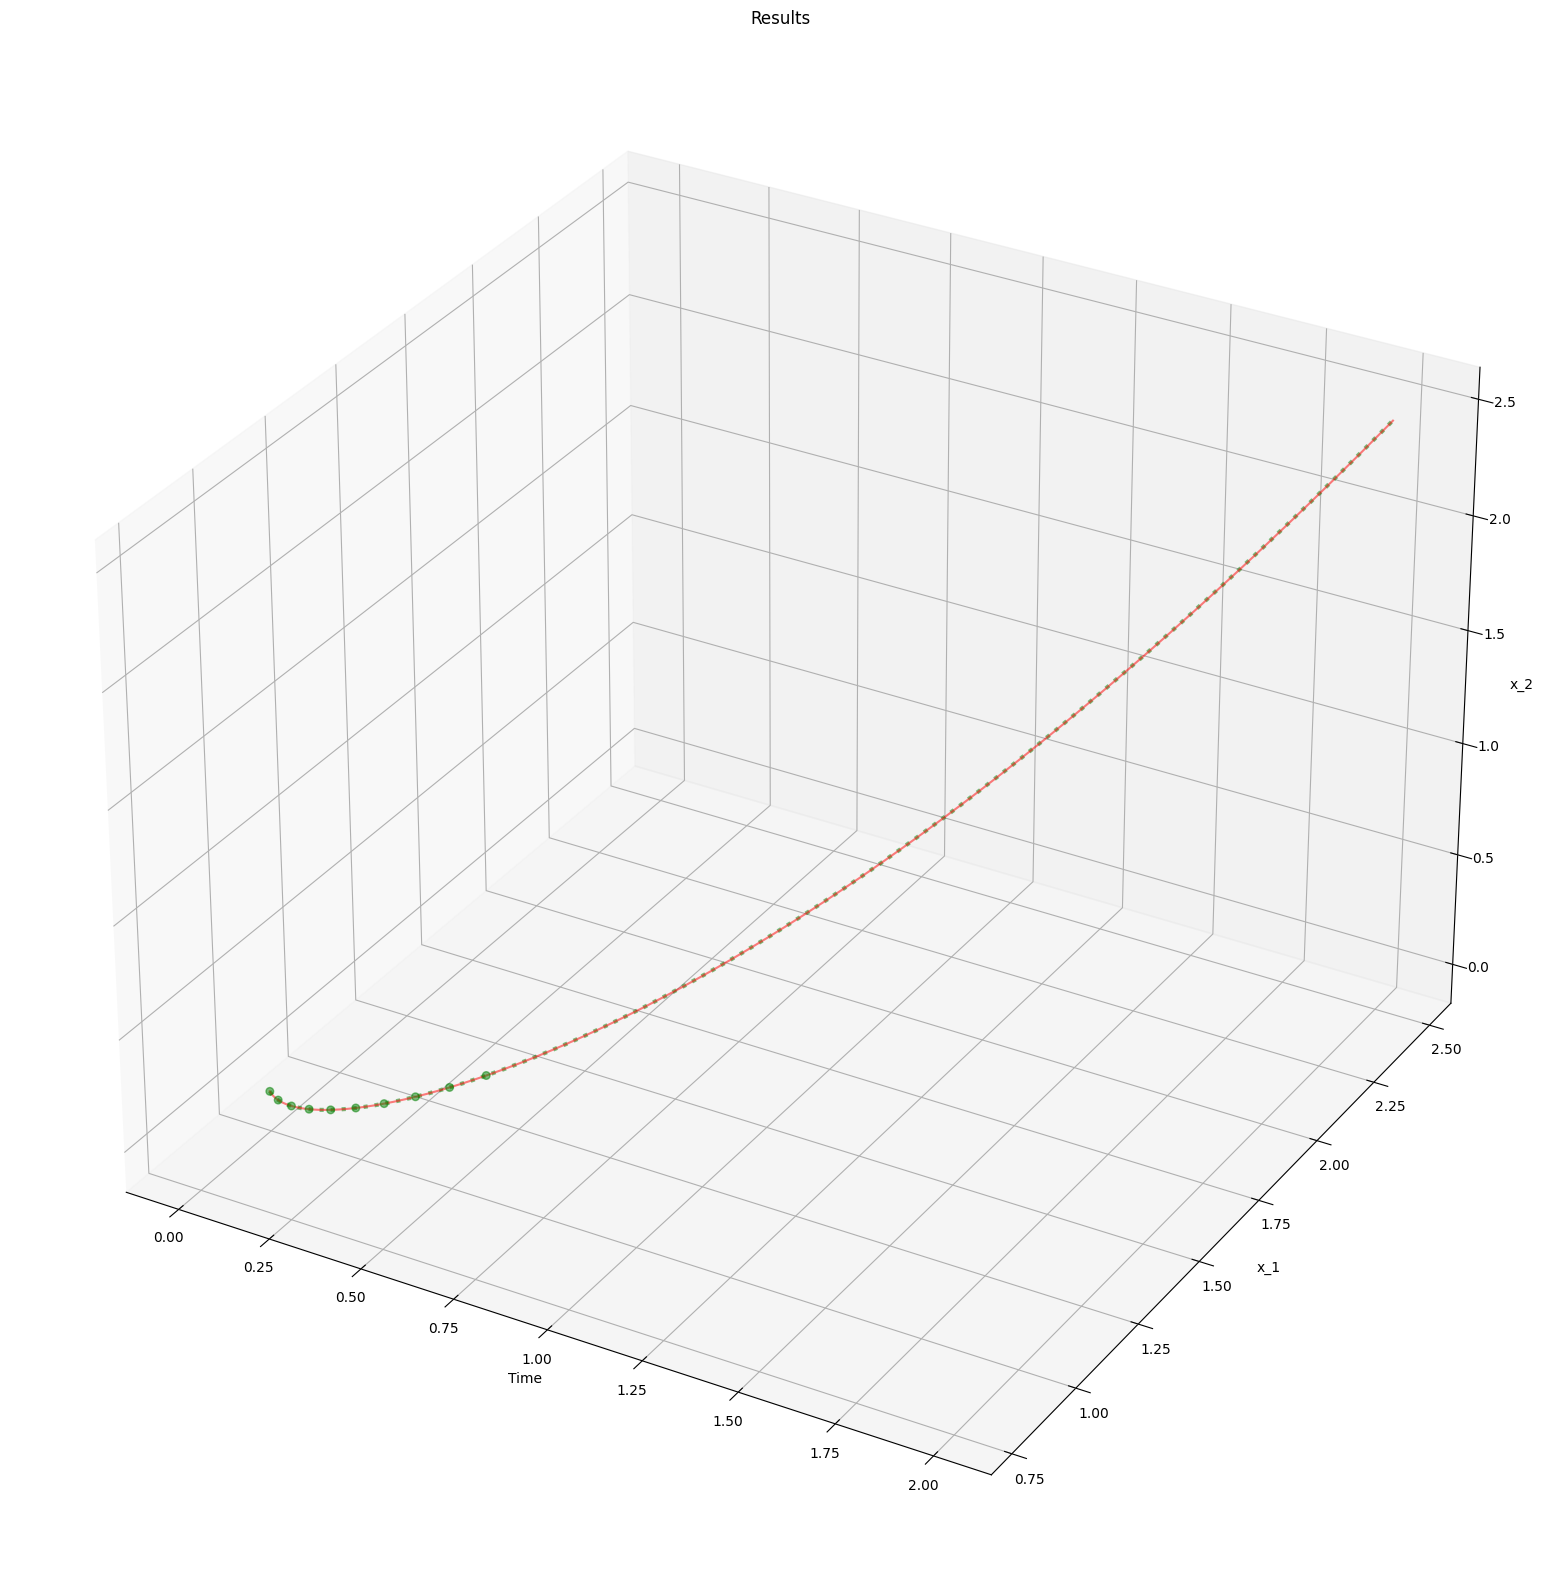

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the figure and axes for the 3D plot
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(t_data.reshape(-1,), x_1_data.reshape(-1,), x_2_data.reshape(-1,),  alpha=0.5, s=30, c='g')
ax.plot(t, x_1, x_2, label="Real solution", linewidth=3, linestyle='dotted', c='g', alpha=0.5)
ax.plot(t, x_1_out.ravel(), x_2_out.ravel(), label="Prediction by PINN", c="r", alpha=0.5)

# Set labels and title
ax.set_xlabel("Time")
ax.set_ylabel("x_1")
ax.set_zlabel("x_2")
ax.set_title("Results")

# Display the 3D plot
plt.show()
